# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
from math import log
entropy = round(-8/10*log(8/10) - 2/10*log(2/10), 2)
entropy

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
H_Rm = 8/10*(1 - 8/10) + 2/10*(1 - 2/10)
H_Rl =  1*(1 - 1) + 0*(1 - 0)
H_Rr =  0*(1 - 0) + 1*(1 - 1)
Q = H_Rm - 8/10 * H_Rl - 2/10 * H_Rr
Q

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

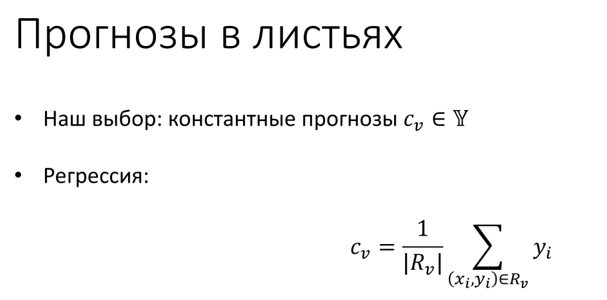

In [ ]:
Rv = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
Cv = np.mean(Rv)
Cv

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [3]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

**Имплементация без циклов:**

комментарии написаны только для одной части, для остальных частей они аналогичны

In [4]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """

    if task == 'regression' and feature_type == 'real':
      # сортируем вектор признаков и относительное его вектор таргетов
      sorted_indices = feature_vector.argsort()
      sorted_feature = feature_vector[sorted_indices]
      sorted_target = target_vector[sorted_indices]

      # определяем уникальные пороги, и создаем список, в котором останутся пороги, при которых нет попадания в поддерево пустого множества
      thresholds = np.unique((sorted_feature[1:] + sorted_feature[:-1])/2)
      thresholds_good = thresholds.tolist()

      # функция подсчета критерия на основе дисперсии
      def variation_real(threshold):

        left_mask = sorted_feature < threshold # маска на объекты, которые попадут в левое поддерево
        right_mask = sorted_feature >= threshold # маска на объекты, которые попадут в правое поддерево

      # удаляем порог, если он приводит к попаданию в поддерево пустого множества
        if len(sorted_target[left_mask]) == 0 or len(sorted_target[right_mask]) == 0:
          if threshold in thresholds_good:
            thresholds_good.remove(threshold)
          return None

        old_gini =  np.var(sorted_target)
        left_gini = np.var(sorted_target[left_mask])
        right_gini = np.var(sorted_target[right_mask])

        total_gini = old_gini - len(sorted_target[left_mask])/len(sorted_target) * left_gini - len(sorted_target[right_mask])/len(sorted_target) * right_gini

        return total_gini

      vec_variation_real = np.vectorize(variation_real) # векторизуем функцию

      ginis = vec_variation_real(thresholds)

      ginis = ginis[ginis != None] # не рассматриваем значения критерия для порогов, которые мы удалили

      best_index = np.argmax(ginis) # индекс наибольшего критерия

      return thresholds_good, ginis, thresholds_good[best_index], ginis[best_index]

    elif task == 'classification' and feature_type == 'real':
      sorted_indices = feature_vector.argsort()
      sorted_feature = feature_vector[sorted_indices]
      sorted_target = target_vector[sorted_indices]

      thresholds = np.unique((sorted_feature[1:] + sorted_feature[:-1])/2)
      thresholds_good = thresholds.tolist()

      # функция подсчета критерия на основе Джини
      def classification_real(threshold):

        left_mask = sorted_feature < threshold
        right_mask = sorted_feature >= threshold

        if len(sorted_target[left_mask]) == 0 or len(sorted_target[right_mask]) == 0:
          if threshold in thresholds_good:
            thresholds_good.remove(threshold)
          return None

        p0 = sum(sorted_target == 0)/len(sorted_target)
        p1 = 1 - p0
        old_gini = p0*(1 - p0) + p1*(1 - p1)

        p0_left = sum(sorted_target[left_mask] == 0)/len(sorted_target[left_mask])
        p1_left = 1 - p0_left
        gini_left = p0_left*(1-p0_left) + p1_left*(1-p1_left)

        p0_right = sum(sorted_target[right_mask] == 0)/len(sorted_target[right_mask])
        p1_right = 1 - p0_right
        gini_right = p0_right*(1-p0_right) + p1_right*(1-p1_right)

        total_gini = old_gini - len(sorted_target[left_mask])/len(sorted_target)*gini_left - len(sorted_target[right_mask])/len(sorted_target) * gini_right

        return total_gini

      vec_classification_real = np.vectorize(classification_real)

      ginis = vec_classification_real(thresholds)

      ginis = ginis[ginis != None]

      best_index = np.argmax(ginis)

      return thresholds_good, ginis, thresholds_good[best_index], ginis[best_index]

    elif task == 'regression' and feature_type == 'categorical':
      sorted_indices = feature_vector.argsort()
      sorted_feature = feature_vector[sorted_indices]
      sorted_target = target_vector[sorted_indices]

      thresholds = np.unique(sorted_feature)
      thresholds_good = thresholds.tolist()

      def variation_categorial(threshold):

        left_mask = sorted_feature == threshold
        right_mask = sorted_feature != threshold

        if len(sorted_target[left_mask]) == 0 or len(sorted_target[right_mask]) == 0:
          if threshold in thresholds_good:
            thresholds_good.remove(threshold)
          return None

        old_gini =  np.var(sorted_target)
        left_gini = np.var(sorted_target[left_mask])
        right_gini = np.var(sorted_target[right_mask])

        total_gini = old_gini - len(sorted_target[left_mask])/len(sorted_target) * left_gini - len(sorted_target[right_mask])/len(sorted_target) * right_gini

        return total_gini

      vec_variation_categorial = np.vectorize(variation_categorial)

      ginis = vec_variation_categorial(thresholds)

      ginis = ginis[ginis != None]

      return thresholds_good, ginis, thresholds_good[best_index], ginis[best_index]

    elif task == 'classification' and feature_type == 'categorical':
      sorted_indices = feature_vector.argsort()
      sorted_feature = feature_vector[sorted_indices]
      sorted_target = target_vector[sorted_indices]

      thresholds = np.unique(sorted_feature)
      thresholds_good = thresholds.tolist()

      def gini_categorial(threshold):

        left_mask = sorted_feature == threshold
        right_mask = sorted_feature != threshold

        if len(sorted_target[left_mask]) == 0 or len(sorted_target[right_mask]) == 0:
          if threshold in thresholds_good:
            thresholds_good.remove(threshold)
          return None

        p0 = sum(sorted_target == 0)/len(sorted_target)
        p1 = 1 - p0
        old_gini = p0*(1 - p0) + p1*(1 - p1)

        p0_left = sum(sorted_target[left_mask] == 0)/len(sorted_target[left_mask])
        p1_left = 1 - p0_left
        gini_left = p0_left*(1-p0_left) + p1_left*(1-p1_left)

        p0_right = sum(sorted_target[right_mask] == 0)/len(sorted_target[right_mask])
        p1_right = 1 - p0_right
        gini_right = p0_right*(1-p0_right) + p1_right*(1-p1_right)

        total_gini = old_gini - len(sorted_target[left_mask])/len(sorted_target)*gini_left - len(sorted_target[right_mask])/len(sorted_target) * gini_right
        return total_gini

      vec_gini_categorial = np.vectorize(gini_categorial)

      ginis = vec_gini_categorial(thresholds)

      ginis = ginis[ginis != None]

      if len(ginis) != 0:
        best_index = np.argmax(ginis)
        return thresholds_good, ginis, thresholds_good[best_index], ginis[best_index]

      else:
        return thresholds_good, ginis, thresholds[0], 0


    pass

Эту функцию можно протестировать на датасете `California`.

In [5]:
from sklearn.datasets import fetch_california_housing

In [6]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [7]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [8]:
thresholds, ginis, threshold_best, gini_best = find_best_split(feature_vector = X['MedInc'].values, target_vector = y, task = 'regression', feature_type = 'real')

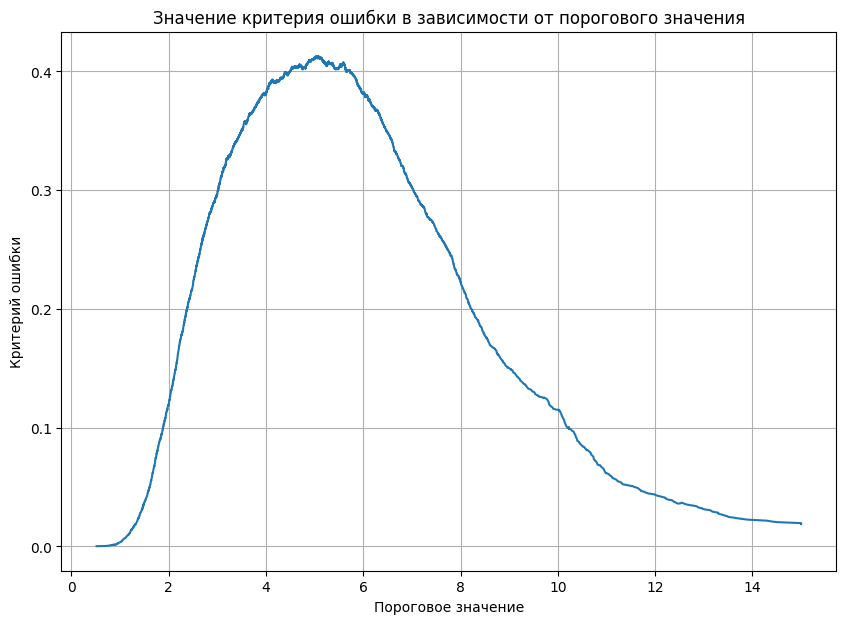

In [9]:
plt.figure(figsize=(10, 7))

plt.plot(thresholds, ginis)
plt.xlabel('Пороговое значение')
plt.ylabel('Критерий ошибки')
plt.title('Значение критерия ошибки в зависимости от порогового значения')
plt.grid()
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [11]:
columns = X.columns

for column in columns:
  thresholds, ginis, threshold_best, gini_best = find_best_split(X[column].values, y, 'regression', 'real')
  print(f'{column}: {gini_best}')

MedInc: 0.41275138620167656
HouseAge: 0.030900940598321186
AveRooms: 0.15920795258922488
AveBedrms: 0.01525341559594362
Population: 0.0028306480479909357
AveOccup: 0.07391870577793286
Latitude: 0.09033408765372021
Longitude: 0.05021105203303022


Наибольшее значение критерия Джини у признака MedInc.

In [14]:
thresholds, ginis, threshold_best, gini_best = find_best_split(feature_vector = X['MedInc'].values, target_vector = y, task = 'regression', feature_type = 'real')

In [16]:
print(f'Лучший предикат первой вершины решающего дерева: MedInc >= {threshold_best}')

Лучший предикат первой вершины решающего дерева: MedInc >= 5.03515


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # если находимся в листе - выводим класс
        if node['type'] == 'terminal':
            return node['class']

        # выводим индекс и значение признака, по которому оптимально сплитить
        feature_index = node['feature_split']
        feature_value = x[feature_index]

        # создаем условие для объектов, которые попадут влево, в зависимости от типа данных
        if self._feature_types[feature_index] == 'real':
            left_condition = feature_value < node['threshold']
        elif self._feature_types[feature_index] == 'categorical':
            left_condition = feature_value == node['category_split']

        # снова вызываем функцию для левого или правого поддерева
        if left_condition:
            return self._predict_node(x, node["left_child"])
        else:
            return self._predict_node(x, node["right_child"])


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
df = pd.read_csv('students.csv')
y = df['UNS']
X = df.drop('UNS', axis = 1)
X.head()

,Unnamed: 0,STG,SCG,STR,LPR,PEG
0,0,0.00,0.00,0.00,0.00,0.00
1,1,0.08,0.08,0.10,0.24,0.90
2,2,0.06,0.06,0.05,0.25,0.33
3,3,0.10,0.10,0.15,0.65,0.30
4,4,0.08,0.08,0.08,0.98,0.24


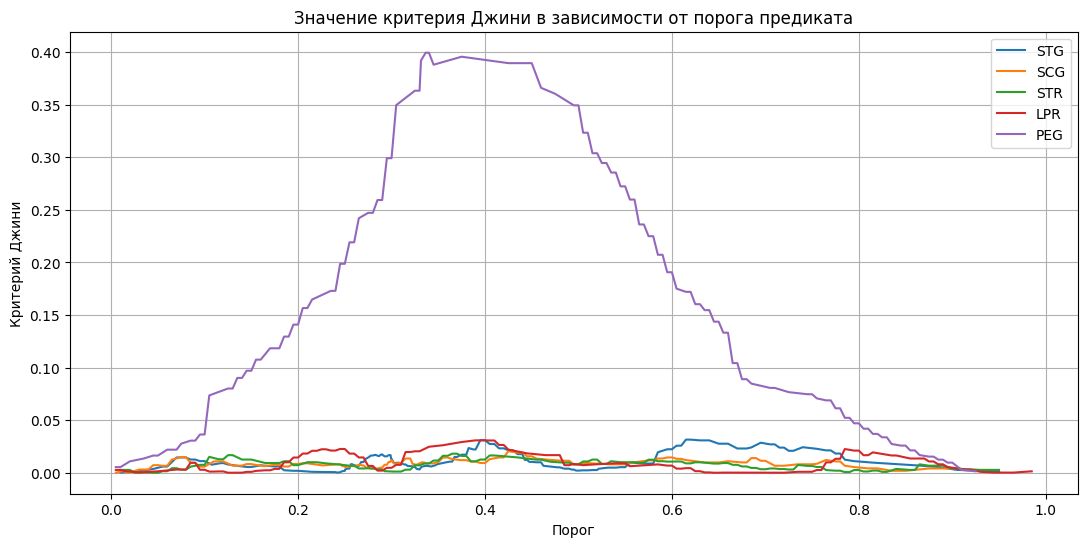

In [ ]:
columns = X.columns[1:]
plt.figure(figsize=(13, 6))

for column in columns:
  thresholds, ginis, threshold_best, gini_best = find_best_split(X[column].values, y.values, 'classification', 'real')
  plt.plot(thresholds, ginis, label = column)

plt.title('Значение критерия Джини в зависимости от порога предиката')
plt.xlabel('Порог')
plt.ylabel('Критерий Джини')
plt.grid()
plt.legend()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

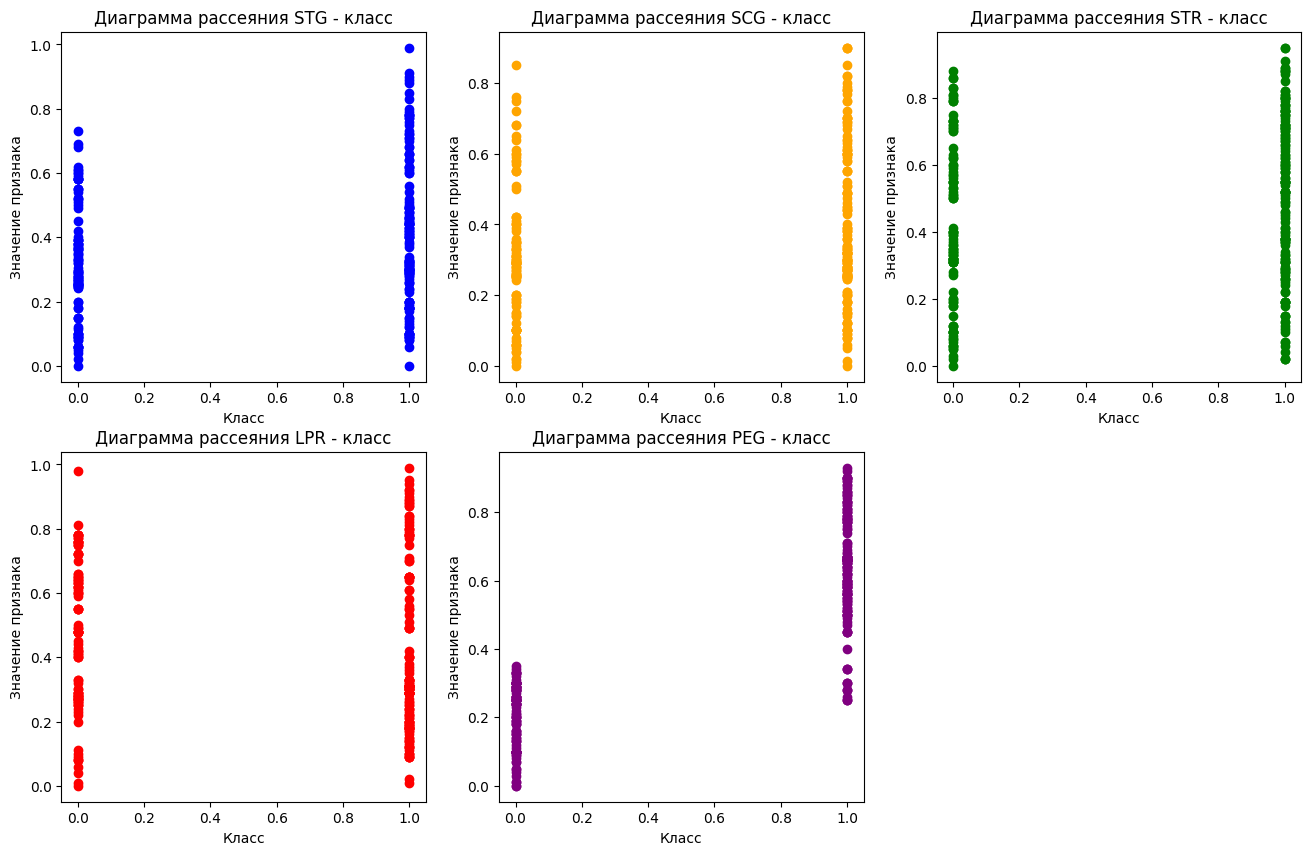

In [ ]:
n = 1
colors = ['blue', 'orange', 'green', 'red', 'purple']
plt.figure(figsize=(16, 10))
for column in columns:
  thresholds, ginis, threshold_best, gini_best = find_best_split(X[column].values, y.values, 'classification', 'real')
  plt.subplot(2, 3, n)
  plt.scatter(y, X[column], color = colors[n-1])
  n += 1
  plt.title(f'Диаграмма рассеяния {column} - класс')
  plt.xlabel('Класс')
  plt.ylabel('Значение признака')

**Вывод:** По графику кривых значений критерия Джини (который мы максимизируем), можно заметить, что лучше всего производить деление по признаку PEG, так как его кривая лежит намного выше кривых других признаков, то есть, при делении по PEG максимальное возможное значение критерия Джини (при пороге примерно 0.35) будет в несколько раз превышать максимальные значения критерия Джини для других признаков. Этот результат согласуется с визуальной оценкой диаграмм рассеяния, так как только для диаграммы PEG класс нулей практически не накладывается на класс единиц по оси Y, то есть классы разделимы, что нельзя сказать для диаграмм других признаков, где возникает пересечение классов практически по всей длине оси Y.

Из этого можно сделать вывод, что для "хороших" признаков вид кривой напоминает колокол, что очень близко к нормальному распределению, а кривые для признаков, по которым деление практически невозможно, выглядят пологими и практически не отличаются между собой.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
df2 = pd.read_csv('agaricus-lepiota.data')
df2.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [ ]:
from sklearn.preprocessing import LabelEncoder
# к каждому столбцу применяем LabelEncoder
for column in df2.columns:
    encoder = LabelEncoder()
    df2[column] = encoder.fit_transform(df2[column])

In [ ]:
from sklearn.model_selection import train_test_split

y = df2['p']
X = df2.drop('p', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 100)

In [ ]:
from sklearn.metrics import accuracy_score

Tree = DecisionTree(feature_types = ['categorical' for x in X_train])
Tree.fit(X_train.values, y_train.values)

y_pred_train = Tree.predict(X_train.values)
y_pred_test = Tree.predict(X_test.values)

print("Accuracy on train:", accuracy_score(y_train, y_pred_train))
print("Accuracy on test:", accuracy_score(y_test, y_pred_test))

Accuracy on train: 1.0
Accuracy on test: 1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

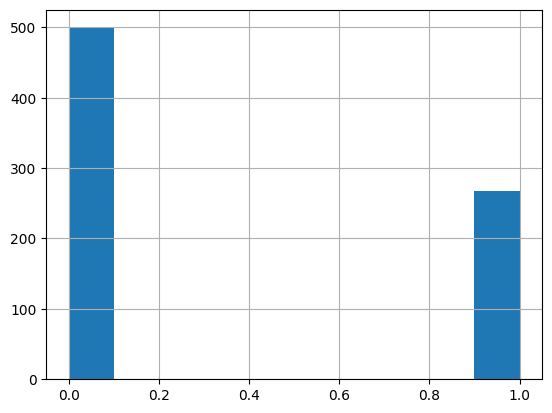

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
from sklearn.model_selection import train_test_split

y = data['Outcome']
X = data.drop('Outcome', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100, shuffle = True)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 100, shuffle = True)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
from sklearn.metrics import f1_score

max_depth = [x for x in range(1, 100)]
min_samples_leaf = [x for x in range(1, 100)]
best_f1 = 0
for depth in max_depth:
  for leaf in min_samples_leaf:
    tree = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = leaf, random_state = 100)
    tree.fit(X_train_train, y_train_train)
    pred_val = tree.predict(X_train_val)
    f1 = f1_score(y_train_val, pred_val)

    # если f1 мера больше лучшей, то меняем лучшие параметры на новые
    if f1 > best_f1:
      best_f1 = f1
      best_max_depth = depth
      best_min_samples_leaf = leaf

print('best_max_depth:',  best_max_depth)
print('best_min_samples_leaf:',  best_min_samples_leaf)

best_max_depth: 6
best_min_samples_leaf: 8


In [ ]:
base_tree = DecisionTreeClassifier(max_depth = best_max_depth, min_samples_leaf = best_min_samples_leaf, random_state = 100)
base_tree.fit(X_train, y_train)
pred = base_tree.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall:", recall_score(y_test, pred))
print("AUC-ROC:", roc_auc_score(y_test, pred))

Accuracy: 0.7229437229437229
Precision: 0.6307692307692307
Recall: 0.5061728395061729
AUC-ROC: 0.6730864197530865


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
bag = BaggingClassifier(base_tree, n_estimators = 50, random_state = 100)
bag.fit(X_train, y_train)
bag_pred = bag.predict(X_test)

print("Accuracy:", accuracy_score(y_test, bag_pred))
print("Precision:", precision_score(y_test, bag_pred))
print("Recall:", recall_score(y_test, bag_pred))
print("AUC-ROC:", roc_auc_score(y_test, bag_pred))

Accuracy: 0.7186147186147186
Precision: 0.6052631578947368
Recall: 0.5679012345679012
AUC-ROC: 0.6839506172839506


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
from sklearn.model_selection import cross_val_score

max_depth = [x for x in range(1, 20)]
min_samples_leaf = [x for x in range(1, 20)]
best_mean_f1 = 0
for depth in max_depth:
  for leaf in min_samples_leaf:
    rf = RandomForestClassifier(n_estimators=50, max_depth = depth, min_samples_leaf = leaf, random_state = 100)
    f1_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring = 'f1')
    mean_f1 = np.mean(f1_scores)

    # если усредненная f1 мера больше лучшей, то меняем лучшие параметры на новые
    if mean_f1 > best_mean_f1:
      best_mean_f1 = mean_f1
      best_max_depth = depth
      best_min_samples_leaf = leaf

print('best_max_depth:',  best_max_depth)
print('best_min_samples_leaf:',  best_min_samples_leaf)

best_max_depth: 6
best_min_samples_leaf: 5


In [ ]:
rf_best = RandomForestClassifier(n_estimators=50, max_depth = best_max_depth, min_samples_leaf = best_min_samples_leaf, random_state = 100)
rf_best.fit(X_train, y_train)
rf_best_pred = rf_best.predict(X_test)

print("Accuracy:", accuracy_score(y_test, rf_best_pred))
print("Precision:", precision_score(y_test, rf_best_pred))
print("Recall:", recall_score(y_test, rf_best_pred))
print("AUC-ROC:", roc_auc_score(y_test, rf_best_pred))

Accuracy: 0.7316017316017316
Precision: 0.6376811594202898
Recall: 0.5432098765432098
AUC-ROC: 0.6882716049382717


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

Text(0.5, 0, 'n_estimators')

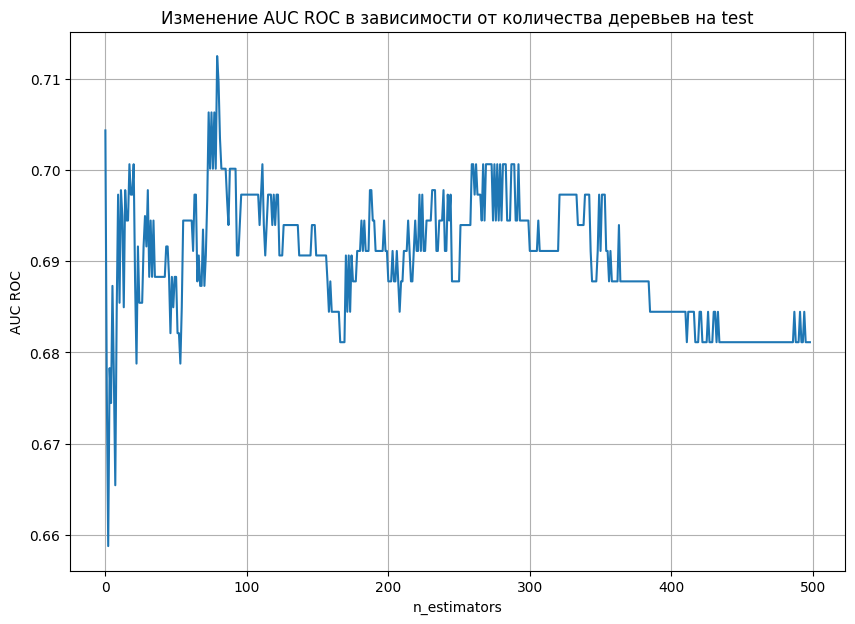

In [ ]:
test_roc_auc = []

for n_estimators in range(1, 500):
    rf = RandomForestClassifier(n_estimators = n_estimators,  max_depth = best_max_depth, min_samples_leaf = best_min_samples_leaf, random_state = 100)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    test_roc_auc.append(roc_auc_score(y_test, rf_pred))

plt.figure(figsize=(10, 7))
plt.title("Изменение AUC ROC в зависимости от количества деревьев на test")
plt.grid()
plt.plot(test_roc_auc)
plt.ylabel("AUC ROC")
plt.xlabel("n_estimators")

**Вывод:** По графику видно, что AUC ROC сначала растет, при росте числа деревьев до 100, потом начинает снижаться, а после 400 деревьев уже меняется несущественно, и при других сидах можно заметить, что при очень большом количестве деревьев график выходит на асимптоту.

В итоге, бэггинг показал наивысший Recall среди других моделей, а случайный лес - accuracy, precision и AUC ROC, так что выбор оптимальной модели зависит от того, какую метрику нам нужно максимизировать для решения задачи.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

Text(0.5, 0, 'Features')

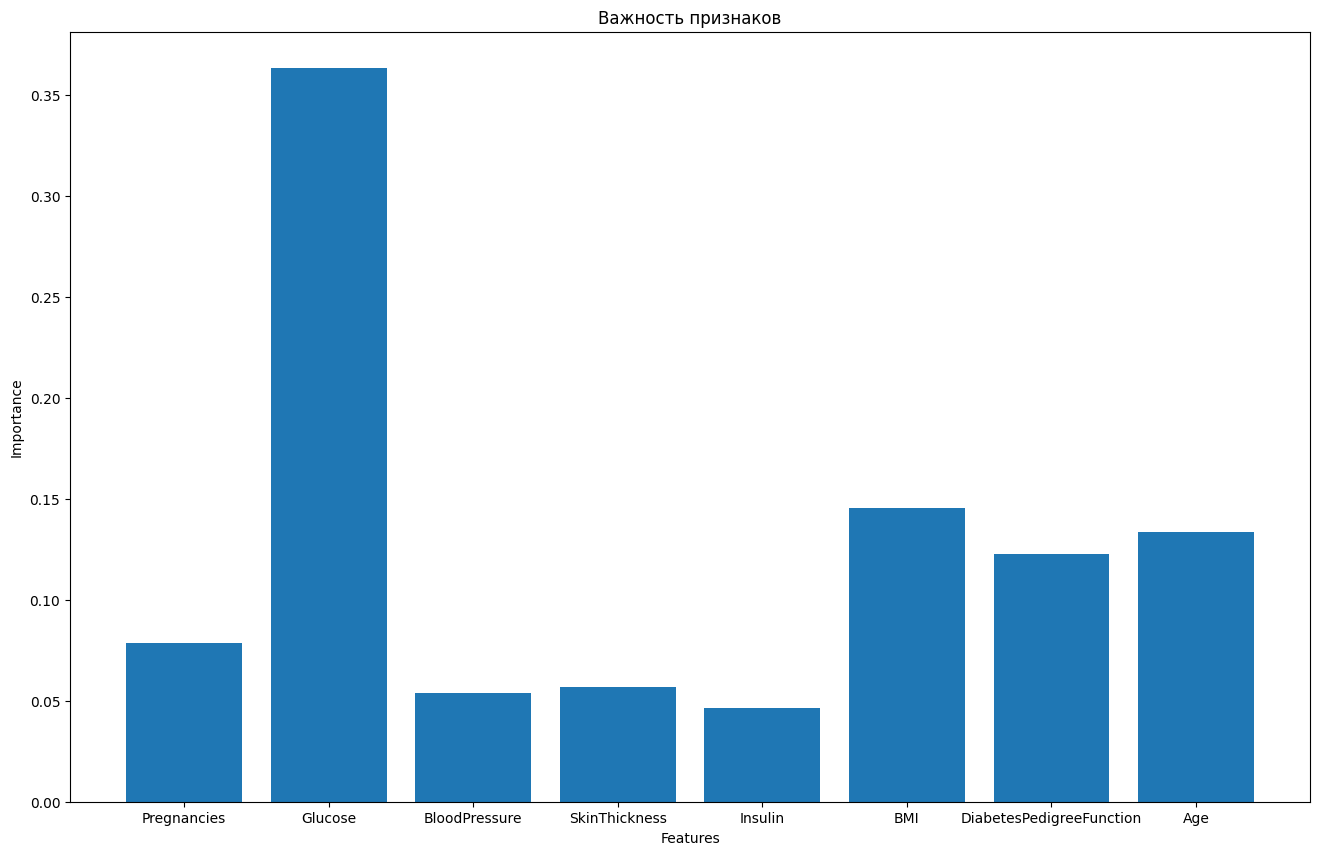

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Важность признаков")
plt.bar(data.drop(['Outcome'], axis=1).columns.values.tolist(), rf_best.feature_importances_)
plt.ylabel("Importance")
plt.xlabel("Features")

**Вывод:** По графику видно, что самым важным признаком для определения диабета является Glucose (уровень глюкозы в крови), что подтверждается и с медицинской точки зрения.